In [29]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import Ridge
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt

In [30]:
import os
import pandas as pd
from pathlib import Path
curr_dir = Path(os.getcwd())
data_dir = curr_dir.parent / "Phase_1" / "train_FD001_phase_1.csv"
df = pd.read_csv(data_dir)

df.head()   

,Engine no,Num cycles,Operating 1,Operating 2,Operating 3,Sensor 1,Sensor 2,Sensor 3,Sensor 4,Sensor 5,...,Sensor 13,Sensor 14,Sensor 15,Sensor 16,Sensor 17,Sensor 18,Sensor 19,Sensor 20,Sensor 21,Stage
0,1,2,0.0019,-0.0003,100.0,518.67,642.15,1591.82,1403.14,14.62,...,2388.07,8131.49,8.4318,0.03,392,2388,100.0,39.00,23.4236,0
1,1,3,-0.0043,0.0003,100.0,518.67,642.35,1587.99,1404.20,14.62,...,2388.03,8133.23,8.4178,0.03,390,2388,100.0,38.95,23.3442,0
2,1,4,0.0007,0.0000,100.0,518.67,642.35,1582.79,1401.87,14.62,...,2388.08,8133.83,8.3682,0.03,392,2388,100.0,38.88,23.3739,0
3,1,5,-0.0019,-0.0002,100.0,518.67,642.37,1582.85,1406.22,14.62,...,2388.04,8133.80,8.4294,0.03,393,2388,100.0,38.90,23.4044,0
4,1,6,-0.0043,-0.0001,100.0,518.67,642.10,1584.47,1398.37,14.62,...,2388.03,8132.85,8.4108,0.03,391,2388,100.0,38.98,23.3669,0


In [31]:
df['RUL'] = df.groupby('Engine no')['Num cycles'].transform(max) - df['Num cycles']

X = df.drop(columns=['Engine no', 'Num cycles', 'RUL', 'Stage'])  # drop identifiers
y = df['RUL']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

C:\Users\deeti\AppData\Local\Temp\ipykernel_27060\998135202.py:1: FutureWarning: The provided callable <built-in function max> is currently using SeriesGroupBy.max. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "max" instead.
  df['RUL'] = df.groupby('Engine no')['Num cycles'].transform(max) - df['Num cycles']


In [32]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV

# Define the parameter grid
param_grid_rf = {
    'n_estimators': [100, 200],
    'max_depth': [10, 20, None],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2]
}

rf = RandomForestRegressor(random_state=42)

# Grid search
grid_rf = GridSearchCV(rf, param_grid_rf, cv=3, scoring='neg_mean_squared_error', n_jobs=-1)
grid_rf.fit(X_train, y_train)

# Best model
best_rf = grid_rf.best_estimator_
print("Best RF params:", grid_rf.best_params_)


Best RF params: {'max_depth': 10, 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 200}


In [33]:
from sklearn.linear_model import Ridge

param_grid_ridge = {
    'alpha': [0.01, 0.1, 1.0, 10.0, 100.0]
}

ridge = Ridge()

grid_ridge = GridSearchCV(ridge, param_grid_ridge, cv=3, scoring='neg_mean_squared_error')
grid_ridge.fit(X_train_scaled, y_train)

best_ridge = grid_ridge.best_estimator_
print("Best Ridge params:", grid_ridge.best_params_)


Best Ridge params: {'alpha': 100.0}


In [34]:
from sklearn.svm import SVR

param_grid_svr = {
    'C': [0.1, 1, 10],
    'epsilon': [0.01, 0.1, 0.5],
    'kernel': ['rbf', 'linear']
}

svr = SVR()

grid_svr = GridSearchCV(svr, param_grid_svr, cv=3, scoring='neg_mean_squared_error', n_jobs=-1)
grid_svr.fit(X_train_scaled, y_train)

best_svr = grid_svr.best_estimator_
print("Best SVR params:", grid_svr.best_params_)


Best SVR params: {'C': 10, 'epsilon': 0.5, 'kernel': 'rbf'}


In [37]:
# Refit models with best parameters
best_rf = RandomForestRegressor(**grid_rf.best_params_, random_state=42)
best_rf.fit(X_train, y_train)
rf_preds = best_rf.predict(X_test)

best_ridge = Ridge(**grid_ridge.best_params_)
best_ridge.fit(X_train_scaled, y_train)
ridge_preds = best_ridge.predict(X_test_scaled)

best_svr = SVR(**grid_svr.best_params_)
best_svr.fit(X_train_scaled, y_train)
svr_preds = best_svr.predict(X_test_scaled)


In [41]:
def evaluate(y_true, y_pred, model_name):
    mse = mean_squared_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)
    print(f"{model_name} - MSE: {mse:.2f}, R²: {r2:.4f}")

evaluate(y_test, rf_preds, "Random Forest (Tuned)")
evaluate(y_test, ridge_preds, "Ridge Regression (Tuned)")
evaluate(y_test, svr_preds, "SVR (Tuned)")


Random Forest (Tuned) - MSE: 1702.43, R²: 0.6266
Ridge Regression (Tuned) - MSE: 1977.53, R²: 0.5663
SVR (Tuned) - MSE: 1724.37, R²: 0.6218


<Figure size 1000x500 with 0 Axes>

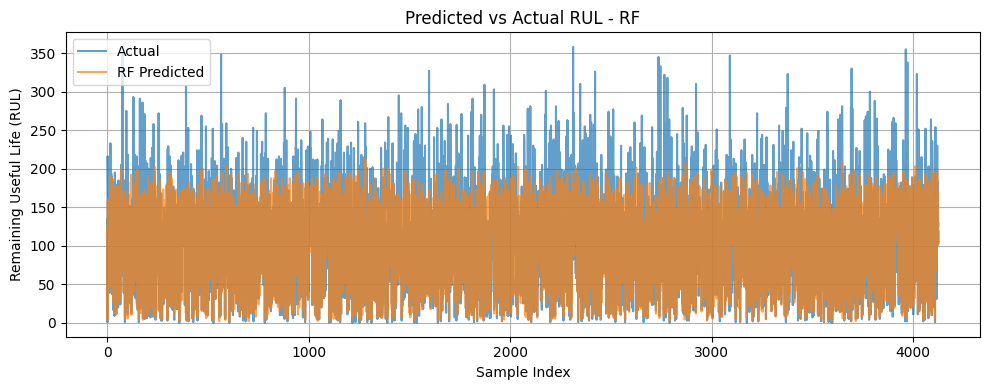

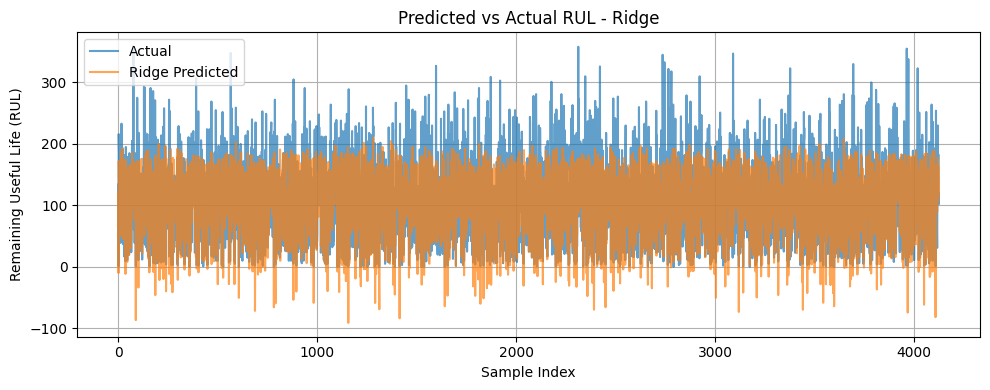

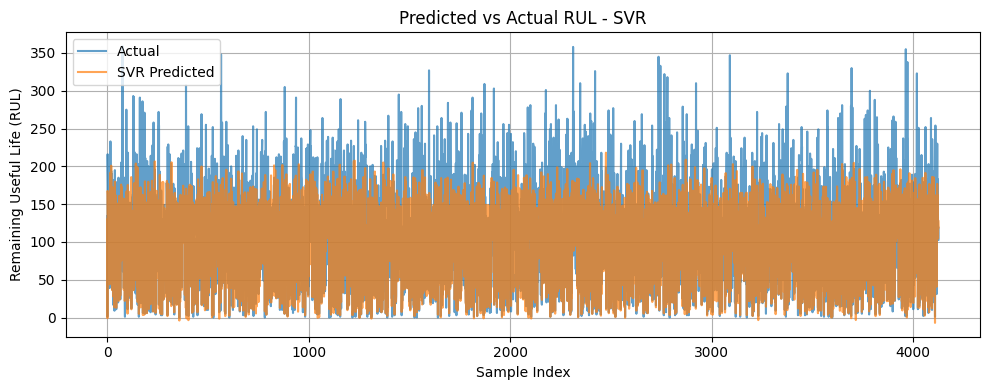

In [43]:
plt.figure(figsize=(10, 5))

# Store model predictions
stage_preds = {
    'RF': rf_preds,
    'Ridge': ridge_preds,
    'SVR': svr_preds
}

# Actual RUL values
stage_actuals = y_test.values

# Plot predictions for each model
for model_name, preds in stage_preds.items():
    plt.figure(figsize=(10, 4))
    plt.plot(stage_actuals, label='Actual', alpha=0.7)
    plt.plot(preds, label=f'{model_name} Predicted', alpha=0.7)
    plt.xlabel('Sample Index')
    plt.ylabel('Remaining Useful Life (RUL)')
    plt.title(f'Predicted vs Actual RUL - {model_name}')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()
